In [70]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit import transpile

import numpy as np
import matplotlib.pyplot as plt

In [169]:
def pauli_channel(p):
    qx = QuantumRegister(1)
    qc = QuantumCircuit(qx, name='Pauli channel')
    rn = np.random.rand()
    if rn < p:
        qc.x(qx)
    else:
        if rn < 2*p:
            qc.y(qx)
        else:
            if rn < 3*p:
                qc.z(qx)
    return qc

In [170]:
def qhc (p):
    H = [[0,0,0,0,0,0,0,1,1,1,1,1,1,1,1], [0,0,0,1,1,1,1,0,0,0,0,1,1,1,1], # the stabilizer matrix H
     [0,1,1,0,0,1,1,0,0,1,1,0,0,1,1], [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1]] 
    Hr = [[1,0,0,0,1,0,1,1,1,0,1,0,1,0,1], [0,1,0,0,0,1,1,1,0,1,1,0,0,1,1], # H in row reduced echelon form
      [0,0,1,0,0,0,0,0,1,1,1,1,1,1,1], [0,0,0,1,1,1,1,0,0,0,0,1,1,1,1]]
    qreg = QuantumRegister(15)
    aregx = AncillaRegister(4)
    aregz = AncillaRegister(4)
    creg = ClassicalRegister(15)
    cregx = ClassicalRegister(4)
    cregz = ClassicalRegister(4)
    qc = QuantumCircuit(qreg, aregx, aregz, cregx, cregz, creg, name='QHC')
    for i in range(4):
        qc.h(qreg[i])
        for j in range(4, 15):
            if Hr[i][j]:
                qc.cx(qreg[i], qreg[j])
    qc.swap(qreg[2], qreg[7])
    for i in range(15):
        qc.compose(pauli_channel(p), qubits = qreg[i], inplace = True)
    for i, row in enumerate(H):
        for j, value in enumerate(row):
            if value:
                qc.cx(qreg[j], aregx[i])
    qc.h(aregz)
    for i, row in enumerate(H):
        for j, value in enumerate(row):
            if value:
                qc.cx(aregz[i], qreg[j])
    qc.h(aregz)
    qc.measure(aregx, cregx)
    qc.measure(aregz, cregz)
    for i in range(15):
        with qc.if_test((cregx, i+1)):
            qc.x(qreg[i])
        with qc.if_test((cregz, i+1)):
            qc.z(qreg[i])
    qc.measure(qreg, creg)
    return qc

In [171]:
def success_prob(p, rounds, sim_shots):
    L0 = ['000000000000000', '000011111111000', '001100111100110', '001111000011110', # components of logical zero state
      '010101011010101', '010110100101101', '011001100110011', '011010011001011', 
      '100101101001011', '100110010110011', '101001010101101', '101010101010101', 
      '110000110011110', '110011001100110', '111100001111000', '111111110000000']
    simulator = AerSimulator()
    successes = 0
    for i in range(rounds):
        compiled_circuit = transpile(qhc(p), simulator)
        job = simulator.run(compiled_circuit, shots = sim_shots)
        counts = job.result().get_counts()
        for key in counts:
            if key[:15] in L0:
                successes += counts[key]
    return successes/rounds

In [ ]:
x_values = np.linspace(0, 0.33, 11)
y_values = []
for p in x_values:
    s = success_prob(p, 100, 1) # finding the success probability for 100 rounds with 1 shot per round
    print(str(p) + ' , ' + str(s))
    y_values.append(s)

0.0 , 1.0
0.033 , 0.5
0.066 , 0.15
0.099 , 0.06
0.132 , 0.04
0.165 , 0.0
0.198 , 0.01
0.231 , 0.0
0.264 , 0.0
0.29700000000000004 , 0.0
0.33 , 0.0


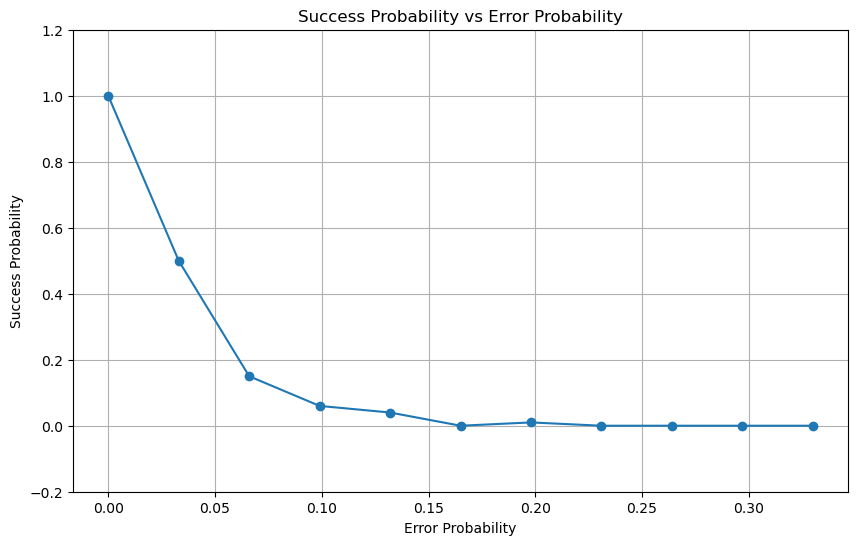

In [168]:
plt.figure(figsize=(10,6))
plt.plot(x_values, y_values, marker='o')
plt.xlabel('Error Probability')
plt.ylabel('Success Probability')
plt.title('Success Probability vs Error Probability')
plt.grid(True)
plt.ylim(-0.2, 1.2)
plt.show()